Задания:

1.Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels

2.Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.

3.Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.

Дополнительно

Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


#### Посмотрим на данные(есть ли пропуски) ####

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Как указано в описании к датасету пропущенные значения есть только у целевой переменной (shot_made_flag) и они сделаны намерено, чтобы отделить часть данных для теста. Для обучения моделей нужны размеченные данные, оставим только их.

In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

#### Посмотрим на таргет ####

In [9]:
data['shot_made_flag'].unique()

array([0., 1.])

In [10]:
data['shot_made_flag'].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

#### Посмотрим на разброс данных в столбцах, определим наличие выбросов и аномалий ####

Графики распределения значений и боксплот для столбца game_event_id 


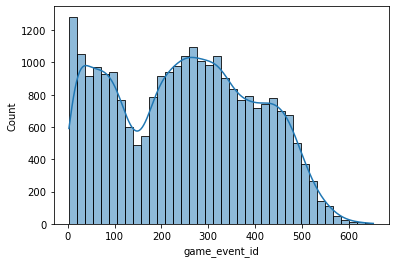

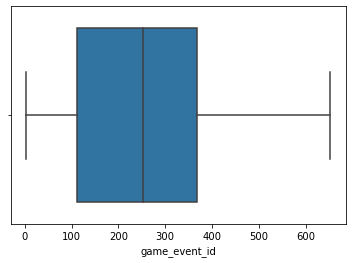

Графики распределения значений и боксплот для столбца game_id 


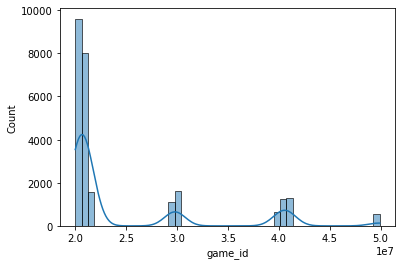

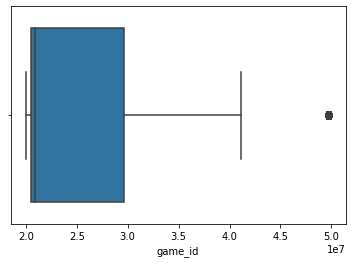

Графики распределения значений и боксплот для столбца lat 


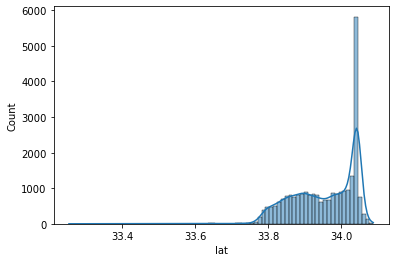

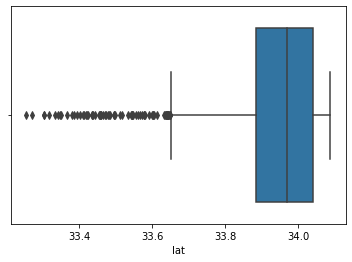

Графики распределения значений и боксплот для столбца loc_x 


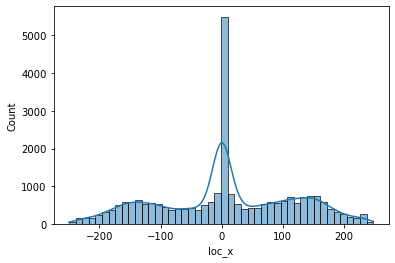

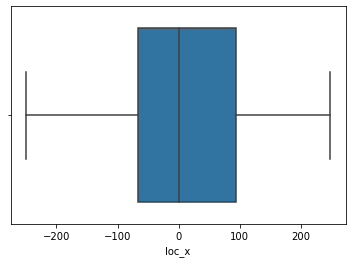

Графики распределения значений и боксплот для столбца loc_y 


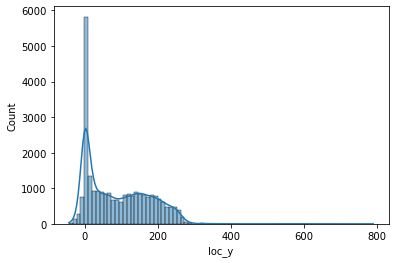

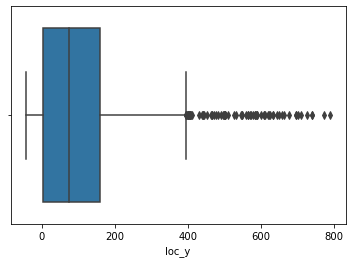

Графики распределения значений и боксплот для столбца lon 


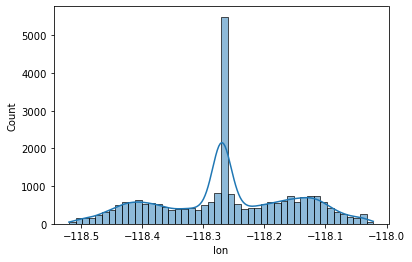

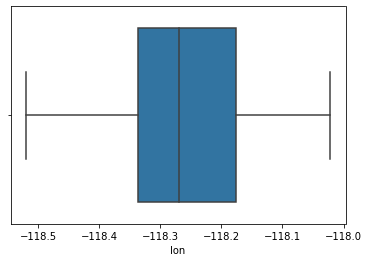

Графики распределения значений и боксплот для столбца minutes_remaining 


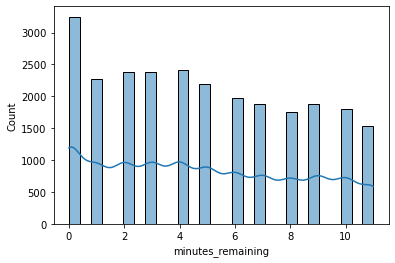

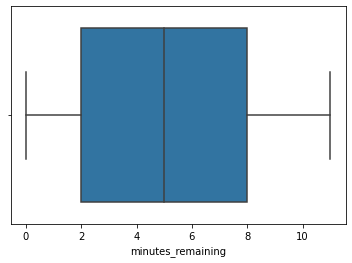

Графики распределения значений и боксплот для столбца period 


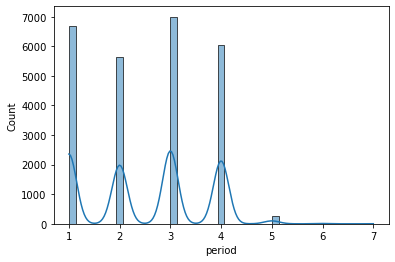

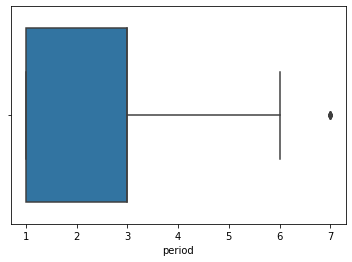

Графики распределения значений и боксплот для столбца playoffs 


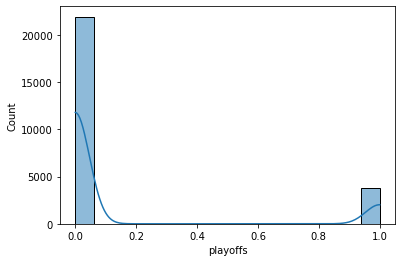

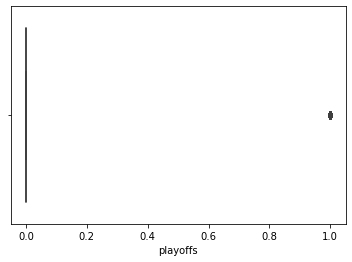

Графики распределения значений и боксплот для столбца seconds_remaining 


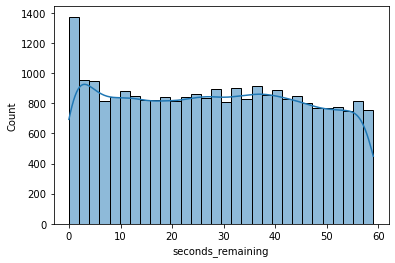

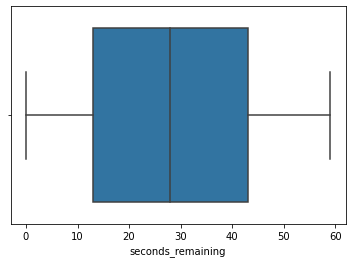

Графики распределения значений и боксплот для столбца shot_distance 


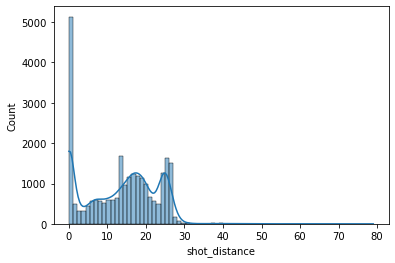

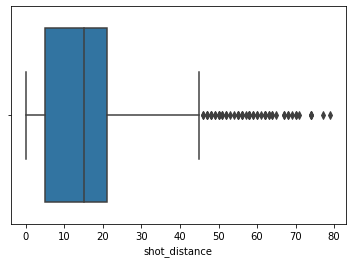

Графики распределения значений и боксплот для столбца shot_made_flag 


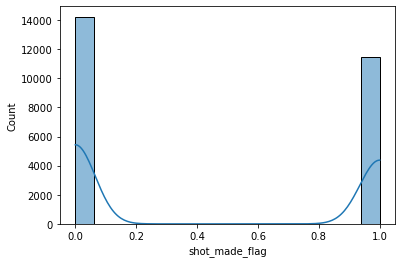

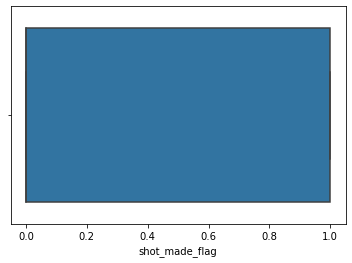

Графики распределения значений и боксплот для столбца team_id 


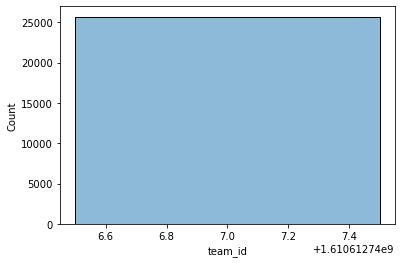

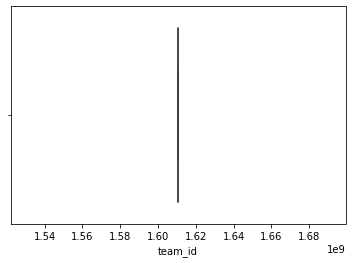

Графики распределения значений и боксплот для столбца shot_id 


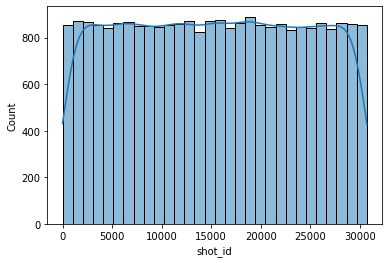

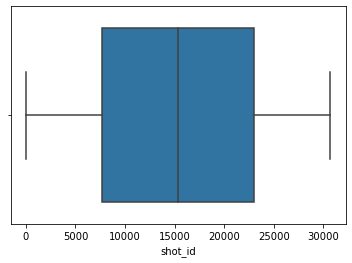

In [11]:
for column in data.columns:
    if data['{}'.format(column)].dtype == 'int64' or data['{}'.format(column)].dtype == 'float64':
        print('Графики распределения значений и боксплот для столбца', '\x1b[1;0346m'+'{} '.format(column) +'\x1b[0m')
        sns.histplot(data=data, x="{}".format(column), kde=True)
        plt.show()
        sns.boxplot(x=data['{}'.format(column)])
        plt.show()

Есть часть столбцов, где нет выбросов: shot_id, team_id, shot_made_flag, seconds_remaining, playoffs (хотя там всего 2 значения: 0 и 1, нулей гораздо больше, поэтому единицы воспринимаются как выбросы), minutes_remaining, lon, loc_x, game_event_id.

Выбросы есть: game_id, lat, loc_y, period, shot_distance. На них обратим внимание. 

Отдельно можно сказать про столбец loc_x: хотя у него и нет выбросов, но большая часть значений лежит у нуля.

    
Так же есть дисбаланс в целевой переменной:

In [12]:
data['shot_made_flag'].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

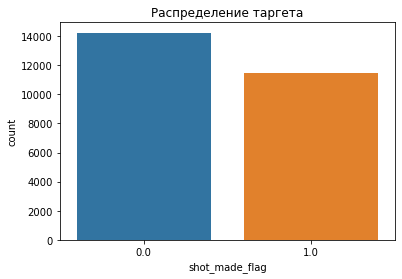

In [13]:
ax = plt.axes()
sns.countplot("shot_made_flag", data=data, ax=ax)
ax.set_title("Распределение таргета")
plt.show()

Не сильно большой диссонанс

#### Посмотрим на статистические показатели ####

In [14]:
desc_num = data.describe(include=['number'])
desc_num

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


Пока непонятно насколько нам нужны значения широты и долготы (lat и lon). Также интересна необходимость столбцов с id.

#### Признаки типа "объект" посмотрим по распределению значений и по их влинию на целевую переменную ####

Влияние значений столбца action_type  на таргет:


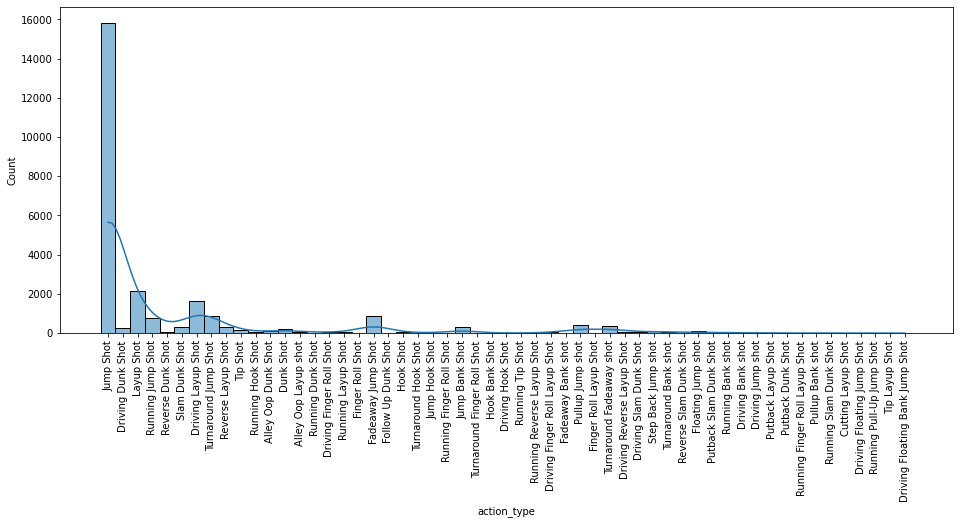

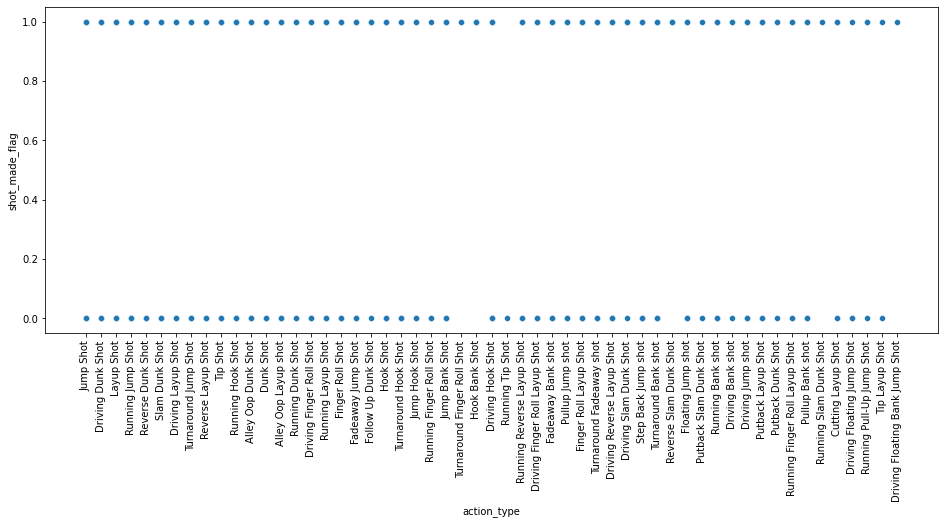

Влияние значений столбца combined_shot_type  на таргет:


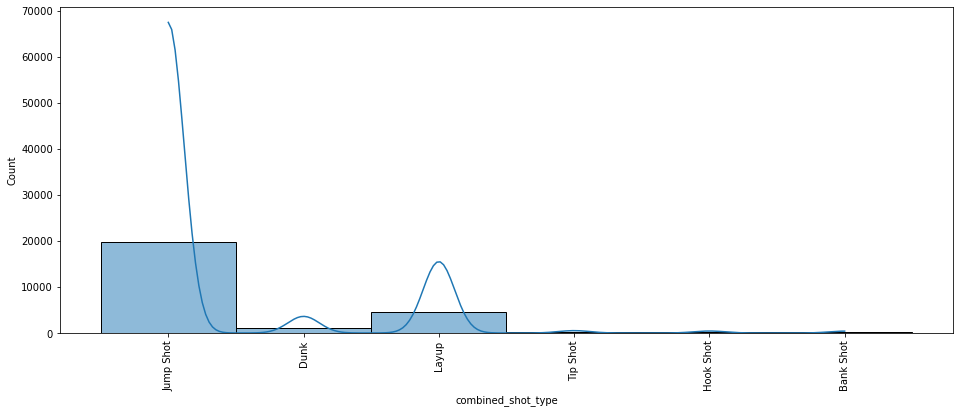

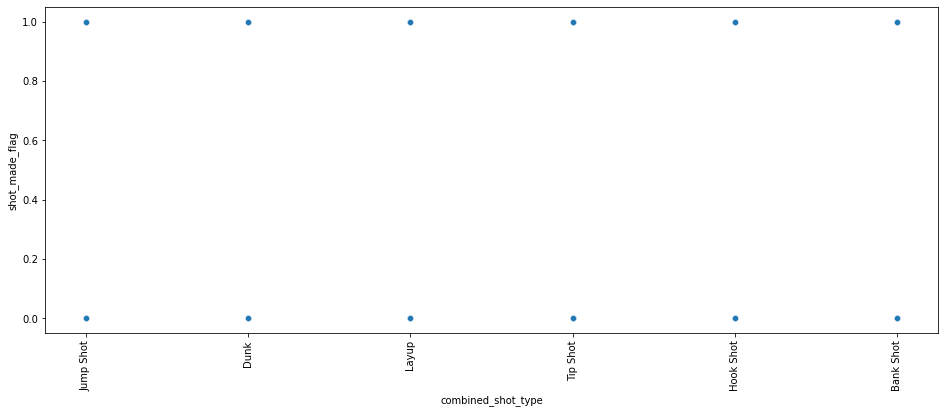

Влияние значений столбца season  на таргет:


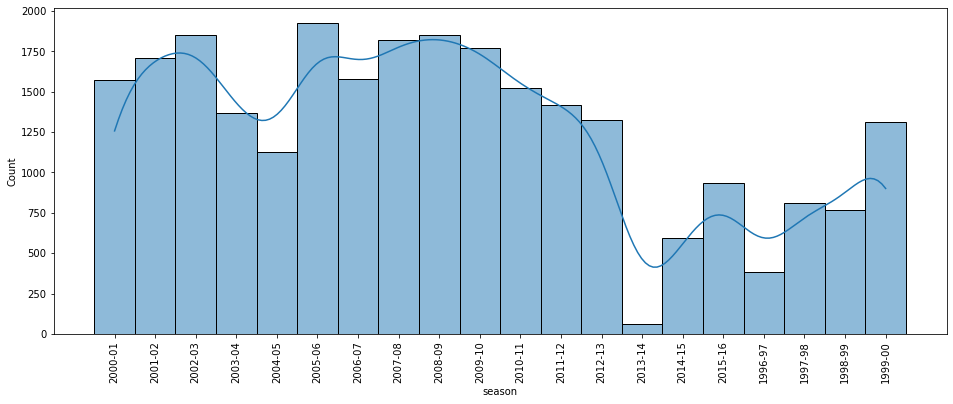

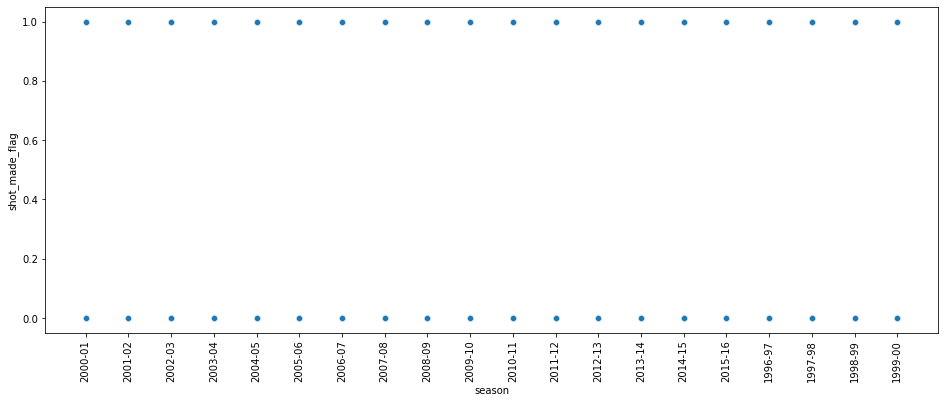

Влияние значений столбца shot_type  на таргет:


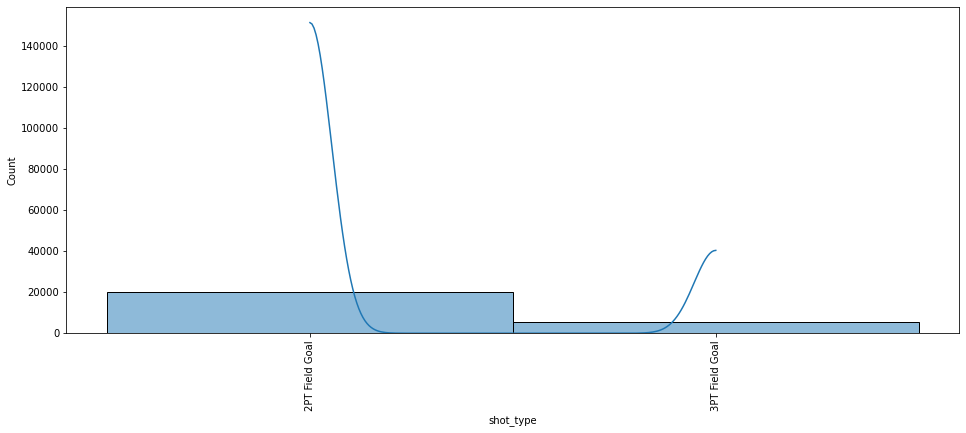

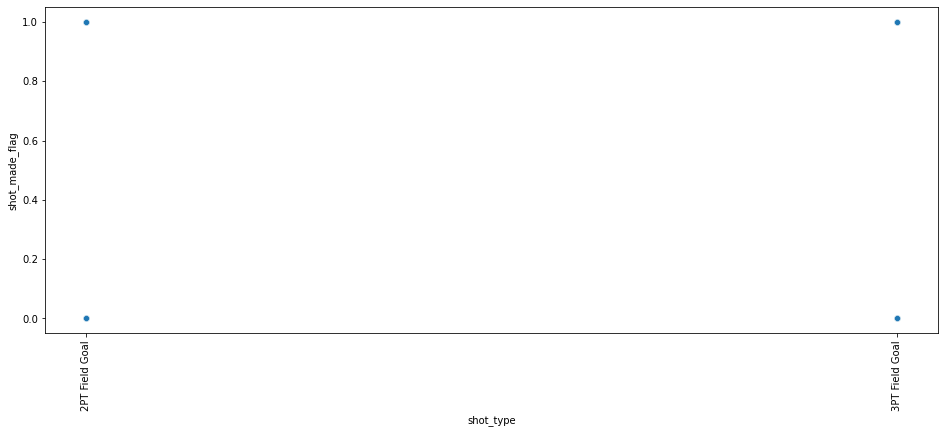

Влияние значений столбца shot_zone_area  на таргет:


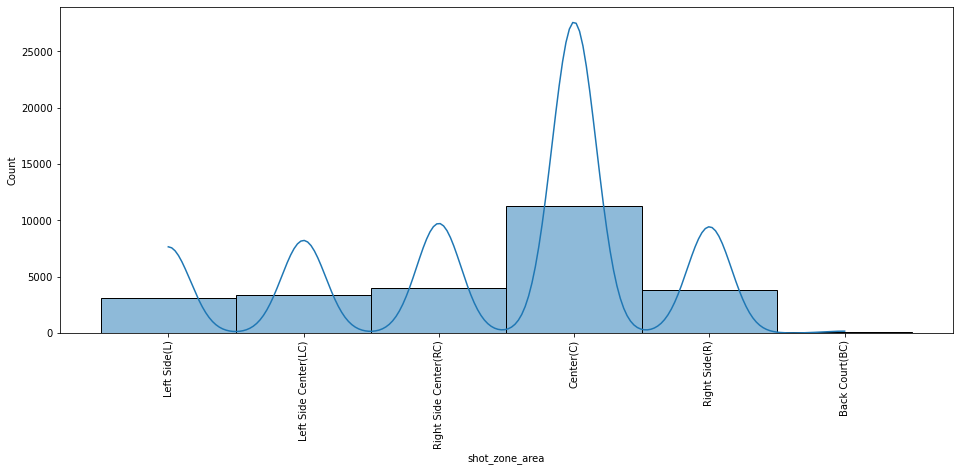

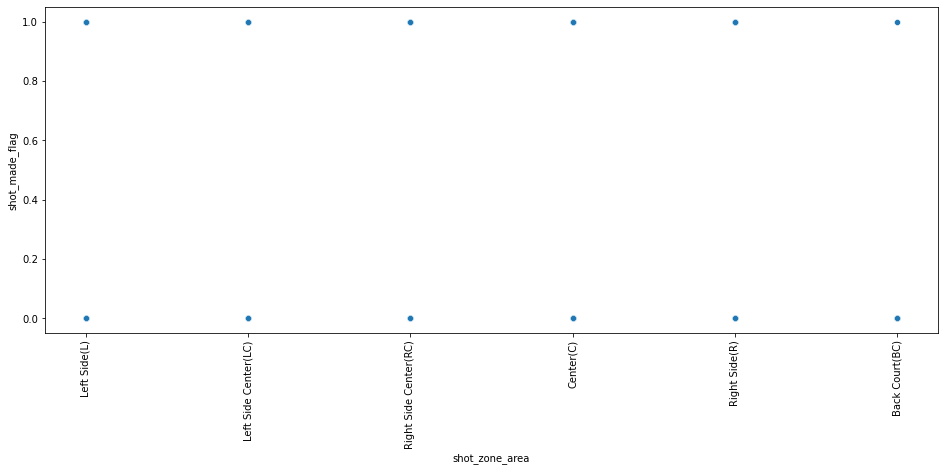

Влияние значений столбца shot_zone_basic  на таргет:


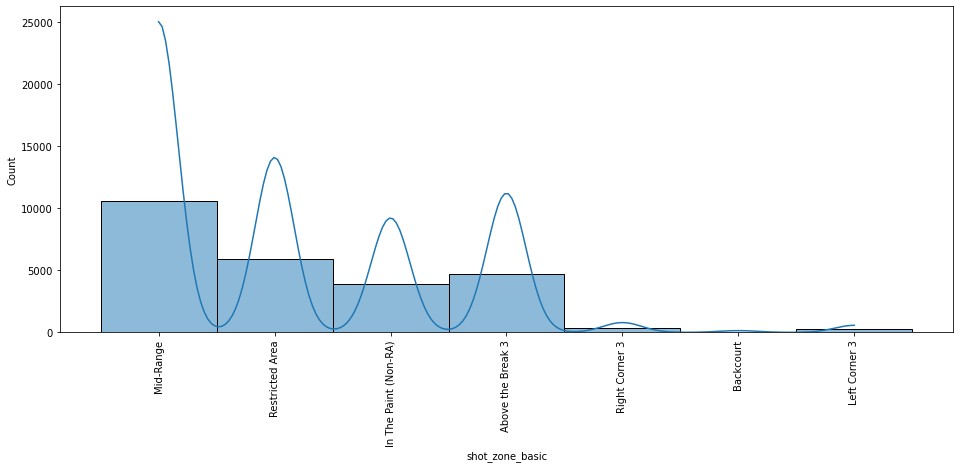

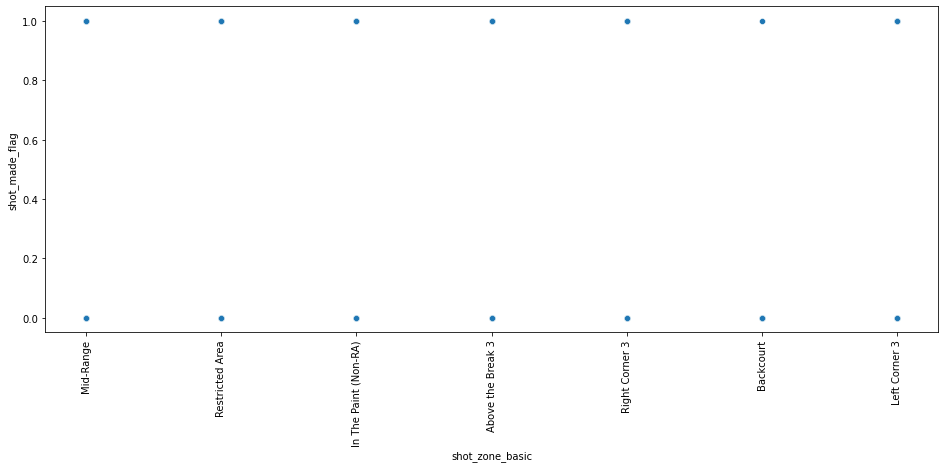

Влияние значений столбца shot_zone_range  на таргет:


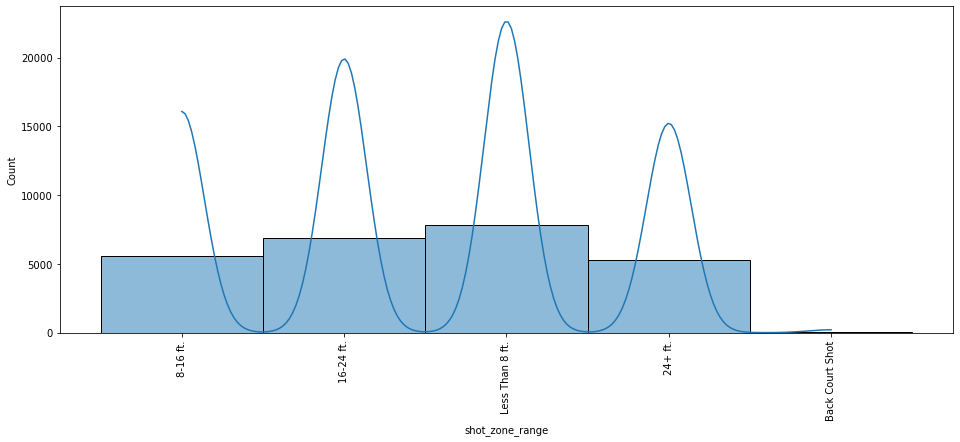

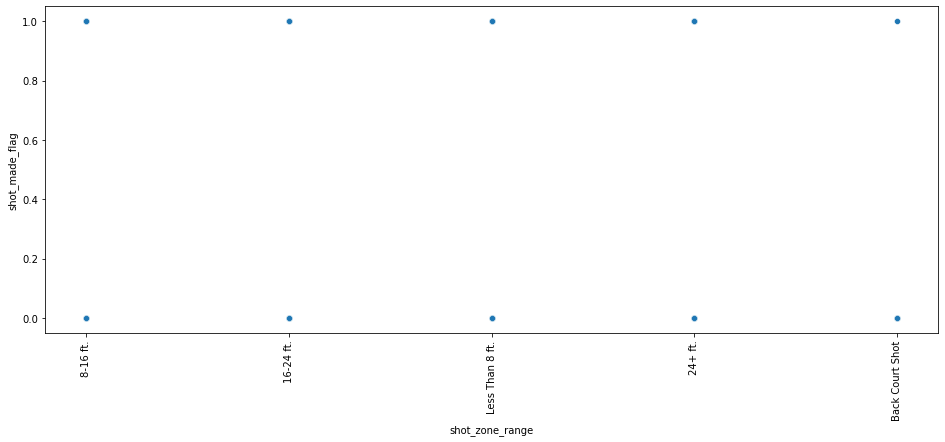

Влияние значений столбца team_name  на таргет:


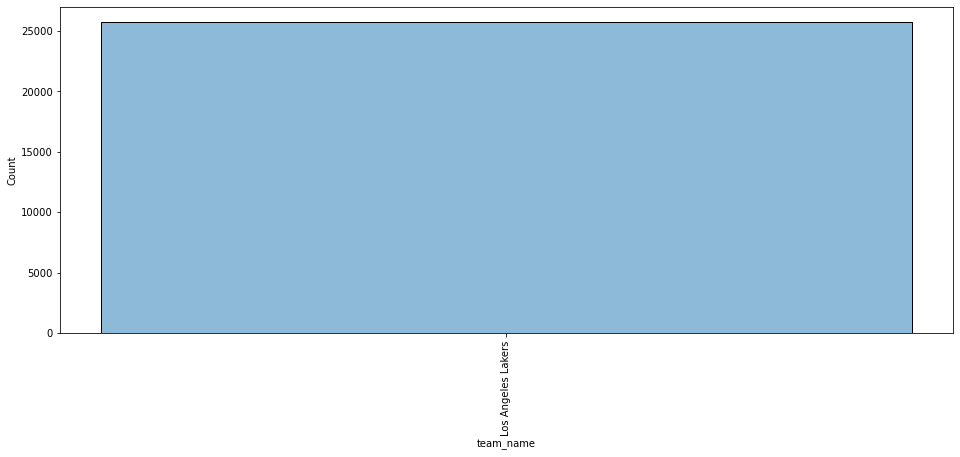

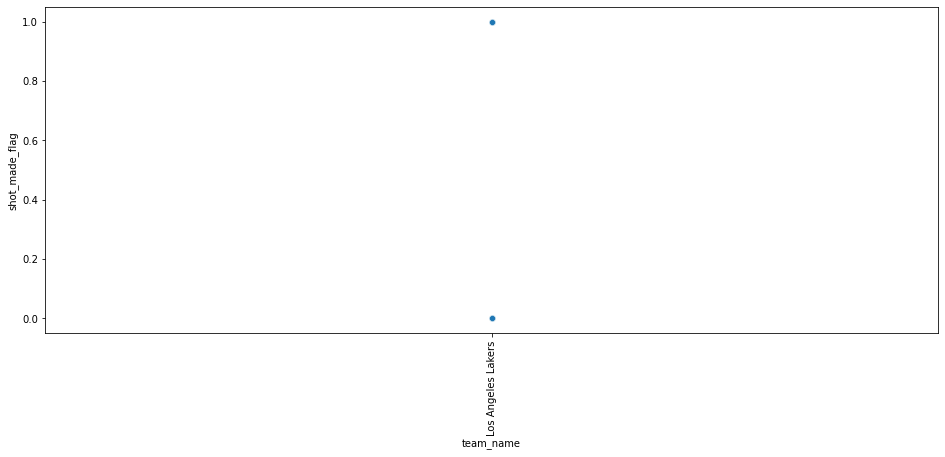

Влияние значений столбца game_date  на таргет:


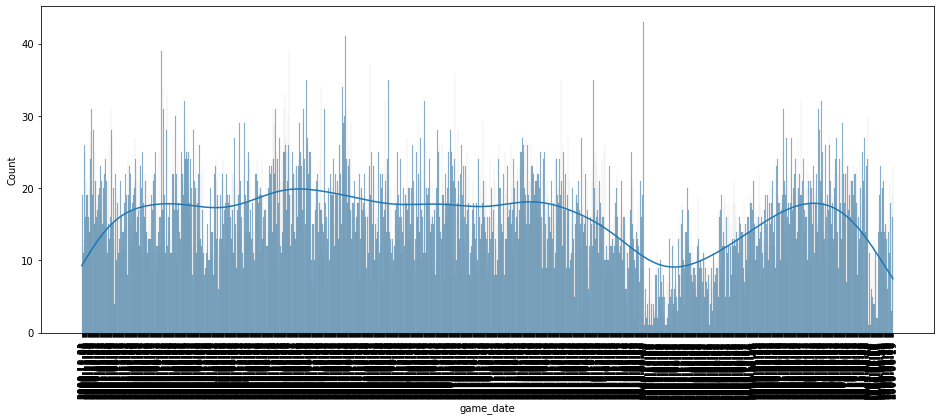

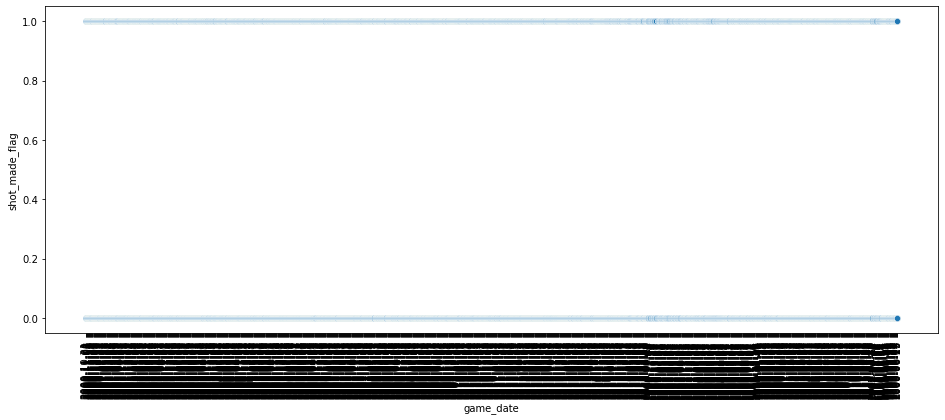

Влияние значений столбца matchup  на таргет:


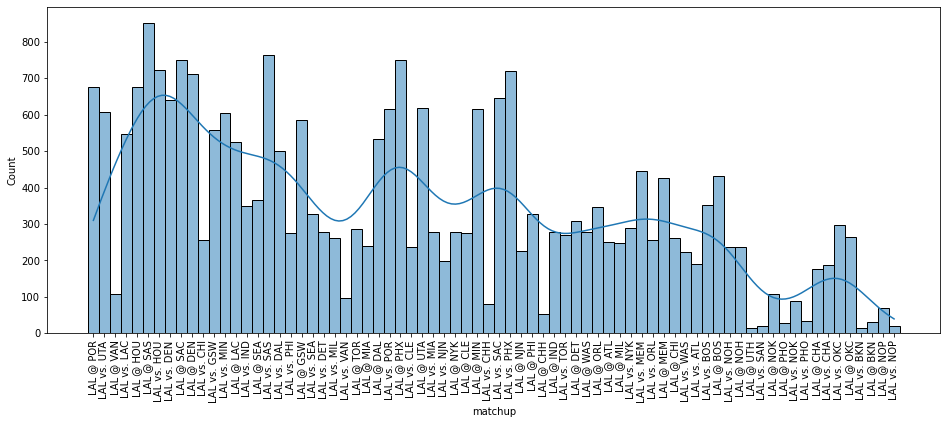

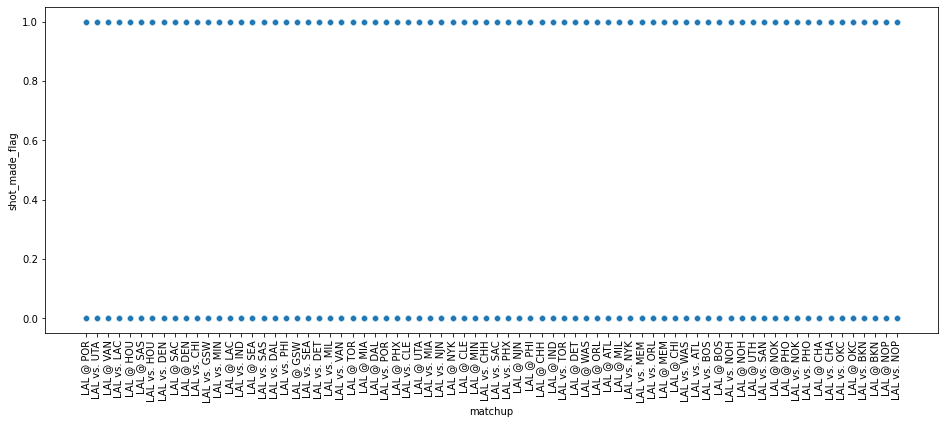

Влияние значений столбца opponent  на таргет:


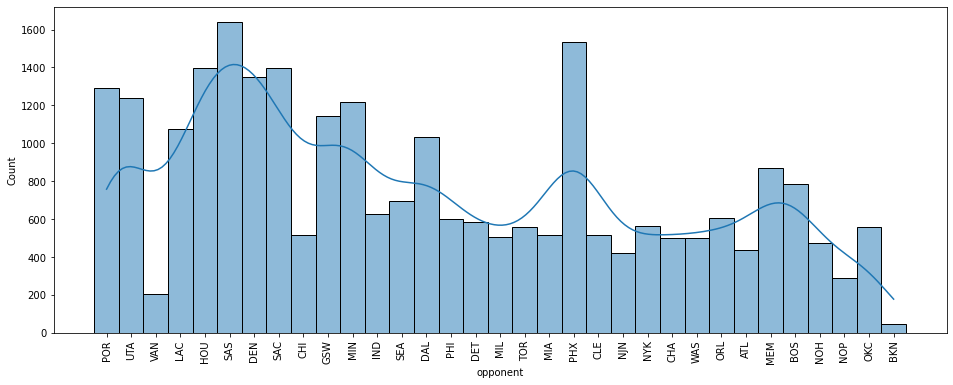

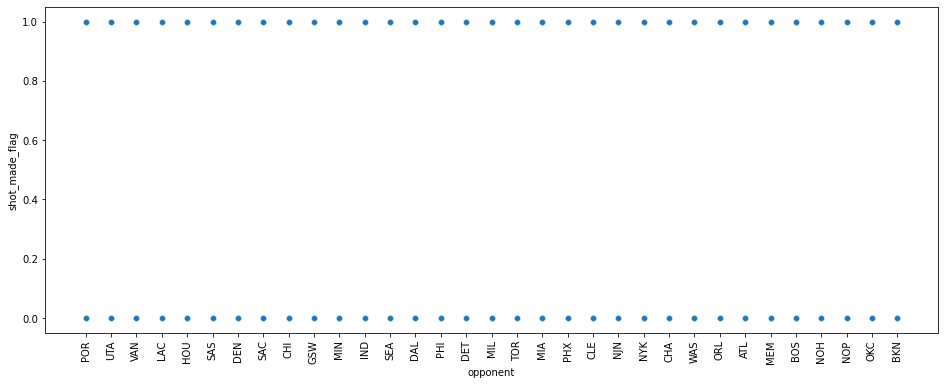

In [16]:
for column in data.columns:
    if data['{}'.format(column)].dtype == 'object':
        print('Влияние значений столбца', '\x1b[1;0346m'+'{} '.format(column) +'\x1b[0m', 'на таргет:')
        plt.figure(figsize=(16, 6))
        sns.histplot(data=data, x="{}".format(column), kde=True)
        plt.tick_params(axis='x', rotation=90)
        plt.show()
        plt.figure(figsize=(16, 6))
        sns.scatterplot(data=data, x='{}'.format(column), y="shot_made_flag")
        plt.tick_params(axis='x', rotation=90)
        plt.show()

При примерно одинаковом количестве попаданий и пропусков есть столбец - action_type. Там видно, что были некоторые зависимости в исходе при принятии того или иного решения. Например, используя Running Tip Shot Кобе промахивался, в то врем как при Reverse Slam Dunk Shot - попадал в цель. Определенно данный признак в какой-то мере влияет на целевую переменную.

Еще бросается в глаза столбец team_name: там только одна команда. Это значит, что столбец нам не нужен - никакого влияния он не оказывает.

Так же нужно обратить внимание на столбцы со временем. Посмотрим на гистограммы для столбцов поближе. Для этого применим тип данных "дата и время" к столбцам и построим гистограммы

In [17]:
data.describe(include=['object'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697
unique,55,6,20,2,6,7,5,1,1558,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,15836,19710,1924,20285,11289,10532,7857,25697,43,853,1638


По этим данным можно увидеть какое значение чаще всего встречается в каждом столбце, так же сколько уникальных значений в столбцах.

#### Удаляем ненужный столбец ####

In [18]:
data['team_name'].unique()

array(['Los Angeles Lakers'], dtype=object)

In [19]:
data = data.drop('team_name', axis=1)
data.shape

(25697, 24)

#### Теперь посмотрим зависимость попадания в кольцо от положения Кобе на поле ####

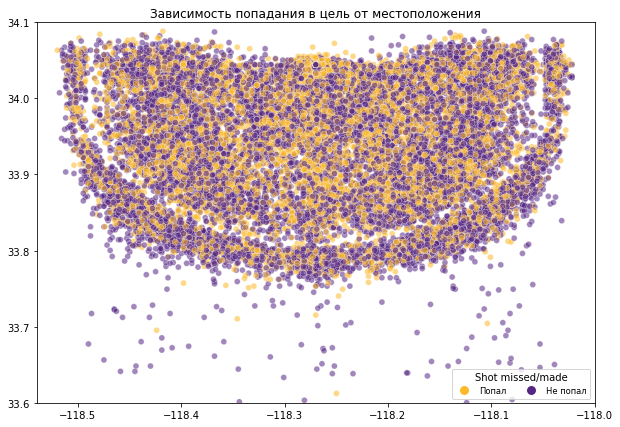

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = sns.scatterplot(x=data["lon"], y=data["lat"], hue=data['shot_made_flag'],
                                    alpha=0.55, ax=ax, palette=("#552583", "#FDB927"))
scatter.set_xlim(left=-118.54, right=-118)
scatter.set_ylim(bottom=33.6, top=34.1)
ax.set_title("Зависимость попадания в цель от местоположения")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Попал",
                         markerfacecolor="#FDB927", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Не попал",
                         markerfacecolor="#552583", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True);

Теперь видно, что из центра гораздо больше попаданий, чем с края поля. Также видна четкая линия, после которой попаданий становится резко меньше, а пропусков больше. В самом низу диаграммы рассеяния зона с самой высокой дисперсией и практически нулевым попаданием. Это логично: от кольца далеко, сама вероятность попадания стремится к нулю.

#### Обработаем столбец с датой ####

In [21]:
data['game_date'] = pd.to_datetime(data['game_date'])

#Создадим новые признаки

data['year'] = pd.DatetimeIndex(data['game_date']).year
data['month'] = pd.DatetimeIndex(data['game_date']).month
data['dayOfWeek']    = data['game_date'].dt.dayofweek
data['dayOfYear']    = data['game_date'].dt.dayofyear

# Удаляем старый столбец

data = data.drop('game_date', axis=1)   

data[['year', 'month', 'dayOfWeek', 'dayOfYear']].head()

,year,month,dayOfWeek,dayOfYear
1,2000,10,1,305
2,2000,10,1,305
3,2000,10,1,305
4,2000,10,1,305
5,2000,10,1,305


#### Построим графики ####

Распределение значений в столбце year 


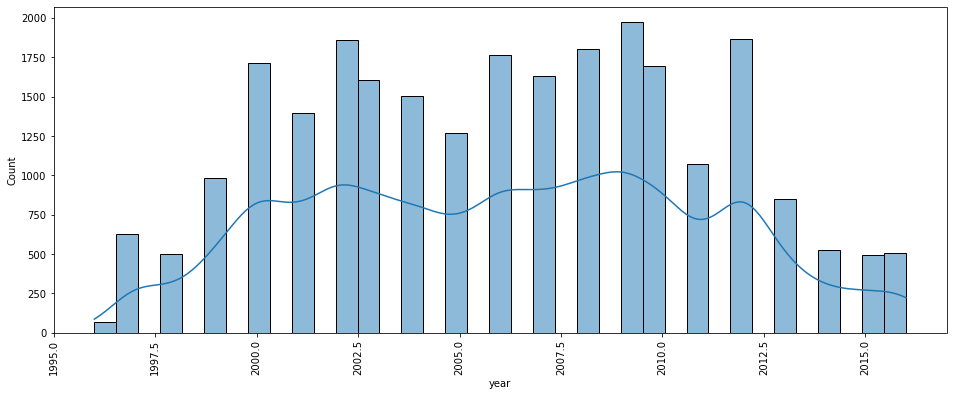

Распределение значений в столбце month 


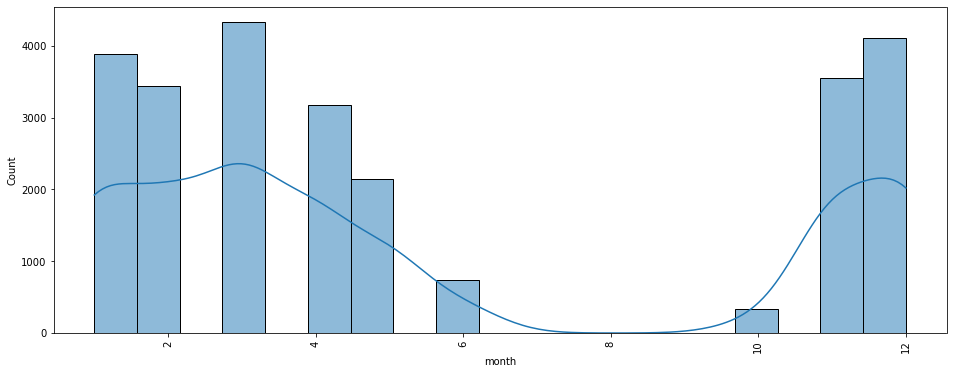

Распределение значений в столбце dayOfWeek 


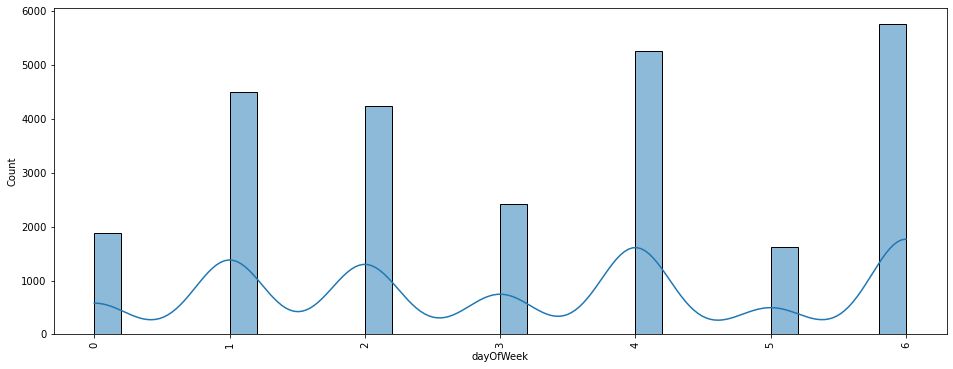

Распределение значений в столбце dayOfYear 


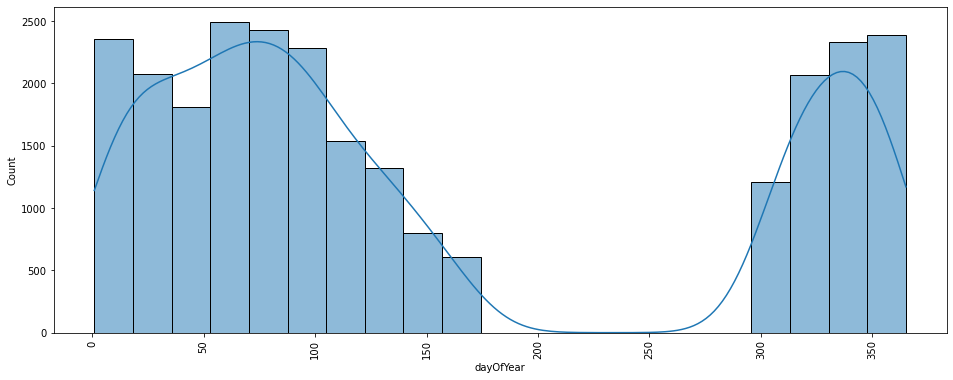

In [22]:
for d in data[['year', 'month', 'dayOfWeek', 'dayOfYear']]:
    print('Распределение значений в столбце', '\x1b[1;0346m'+'{} '.format(d) +'\x1b[0m')
    plt.figure(figsize=(16, 6))
    sns.histplot(data=data, x="{}".format(d), kde=True)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

Чаще всего Кобе играл по воскресеньям, пятницам и вторникам; летом и в начале осени был отпуск (или перерыв), а во второй половине осени и зимой были матчи. Если обратить внимание на годы игр, то увидим, что самые активные периоды - 2000 - 2012.

#### Переведем категориальные признаки в формат, удобрый для обучения моделей ####

In [23]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,12,20000012,34.0443,-157,0,-118.4268,10,1,0,22,...,0,0,1,0,0,0,0,0,0,0
2,35,20000012,33.9093,-101,135,-118.3708,7,1,0,45,...,0,0,1,0,0,0,0,0,0,0
3,43,20000012,33.8693,138,175,-118.1318,6,1,0,52,...,0,0,1,0,0,0,0,0,0,0
4,155,20000012,34.0443,0,0,-118.2698,6,2,0,19,...,0,0,1,0,0,0,0,0,0,0
5,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,32,...,0,0,1,0,0,0,0,0,0,0


И поскольку тип данных в новых столбцах "uint8", изменим его на целые числа

In [24]:
col_to_int = []
for col in data.columns:
    if data[col].dtype == 'uint8':
        col_to_int.append(col)

In [25]:
for i in col_to_int:
    data[i] = data[i].astype('int64')

#### Oтделим таргет от фичей ####

In [26]:
features = data.drop('shot_made_flag', axis=1)
target = data['shot_made_flag']
features.shape, target.shape

((25697, 216), (25697,))

In [27]:
target.isna().sum()

0

#### Разделим выборку на 3 части ####

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

In [29]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

In [30]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((15418, 216), (5139, 216), (5140, 216), (15418,), (5139,), (5140,))

In [31]:
num = desc_num.columns.to_numpy().tolist()
num.remove('shot_made_flag')
num

['game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'seconds_remaining',
 'shot_distance',
 'team_id',
 'shot_id']

In [32]:
scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])
features_test.head()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
17869,-0.460146,-0.484365,-0.718039,-0.049935,0.718039,-0.049935,0.040598,-0.448868,-0.415512,-0.595286,...,0,0,0,0,0,0,0,0,0,0
28660,1.739626,2.072457,1.036993,-0.068042,-1.036993,-0.068042,-0.250129,1.279348,2.406672,-0.709185,...,0,0,0,0,0,0,0,0,0,0
1753,0.033136,-0.600704,1.104495,1.271898,-1.104495,1.271898,1.203503,0.415240,-0.415512,-0.766135,...,0,0,0,0,0,0,0,0,0,0
11135,-1.180072,-0.536025,-0.290531,1.117986,0.290531,1.117986,-0.250129,-1.312976,-0.415512,1.625749,...,0,0,0,0,0,0,0,0,0,0
30008,-0.033524,2.111200,1.036993,-0.031828,-1.036993,-0.031828,-0.540855,-0.448868,2.406672,0.429807,...,0,0,0,0,0,0,0,0,0,0


Пробуем обучить как есть логистическую регрессию

In [33]:
log_reg = LogisticRegression(random_state=12345).fit(features_train, target_train)

In [34]:
predict_proba = log_reg.predict_proba(features_valid)
print(classification_report(target_valid, log_reg.predict(features_valid), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.67      0.83      0.74      2846
     class 1       0.70      0.48      0.57      2293

    accuracy                           0.68      5139
   macro avg       0.68      0.66      0.66      5139
weighted avg       0.68      0.68      0.67      5139



Результат пока не очень. Посмотрим на важность признаков.

Feature: game_event_id, Score: -0.00396
Feature: game_id, Score: 0.01690
Feature: lat, Score: -0.04126
Feature: loc_x, Score: 0.00588
Feature: loc_y, Score: 0.04126
Feature: lon, Score: 0.00588
Feature: minutes_remaining, Score: 0.05335
Feature: period, Score: -0.03650
Feature: playoffs, Score: 0.02679
Feature: seconds_remaining, Score: 0.03754
Feature: shot_distance, Score: -0.11326
Feature: team_id, Score: 0.00000
Feature: shot_id, Score: -0.07473
Feature: year, Score: 0.00045
Feature: month, Score: -0.02774
Feature: dayOfWeek, Score: 0.00228
Feature: dayOfYear, Score: 0.00066
Feature: action_type_Alley Oop Layup shot, Score: 0.00979
Feature: action_type_Cutting Layup Shot, Score: -0.00011
Feature: action_type_Driving Bank shot, Score: 0.00072
Feature: action_type_Driving Dunk Shot, Score: 0.17621
Feature: action_type_Driving Finger Roll Layup Shot, Score: 0.02990
Feature: action_type_Driving Finger Roll Shot, Score: 0.03225
Feature: action_type_Driving Floating Bank Jump Shot, Score

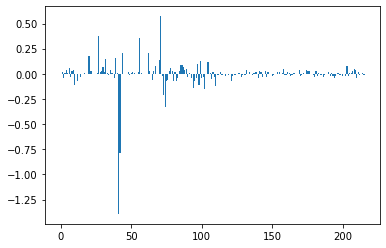

In [35]:
importance = log_reg.coef_[0]

features_important = pd.DataFrame()
feat = []
score = []

for i,v in enumerate(importance):
    feat.append(features_train.columns[i])
    score.append(v)
    print('Feature: %0s, Score: %.5f' % (features_train.columns[i],v))

features_important['feature'] = feat
features_important['score'] = score
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [36]:
features_important.sort_values('score').head(10)

,feature,score
41,action_type_Jump Shot,-1.393314
42,action_type_Layup Shot,-0.791833
74,combined_shot_type_Layup,-0.328935
73,combined_shot_type_Jump Shot,-0.208038
102,shot_zone_basic_In The Paint (Non-RA),-0.146783
94,season_2015-16,-0.137204
110,shot_zone_range_Less Than 8 ft.,-0.117898
10,shot_distance,-0.113262
98,shot_zone_area_Left Side(L),-0.107707
82,season_2003-04,-0.074742


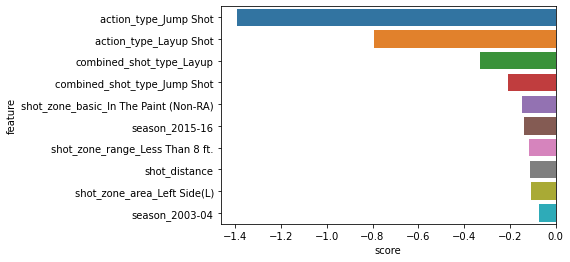

In [37]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').head(10))
plt.show()

In [38]:
features_important.sort_values('score').tail(10)

,feature,score
99,shot_zone_area_Right Side Center(RC),0.129063
70,action_type_Turnaround Jump Shot,0.140708
32,action_type_Fadeaway Jump Shot,0.151659
39,action_type_Jump Bank Shot,0.155219
20,action_type_Driving Dunk Shot,0.176213
62,action_type_Slam Dunk Shot,0.204358
44,action_type_Pullup Jump shot,0.204702
56,action_type_Running Jump Shot,0.352675
27,action_type_Driving Layup Shot,0.376908
71,combined_shot_type_Dunk,0.572245


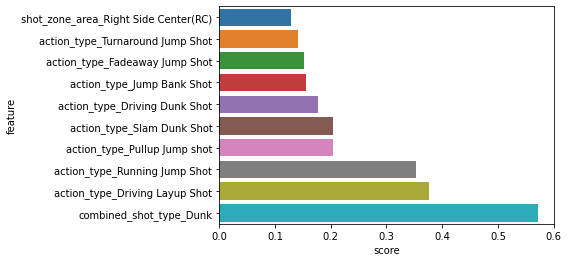

In [39]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').tail(10))
plt.show()

Еще раз посмотрим на наиболее значимые признаки.

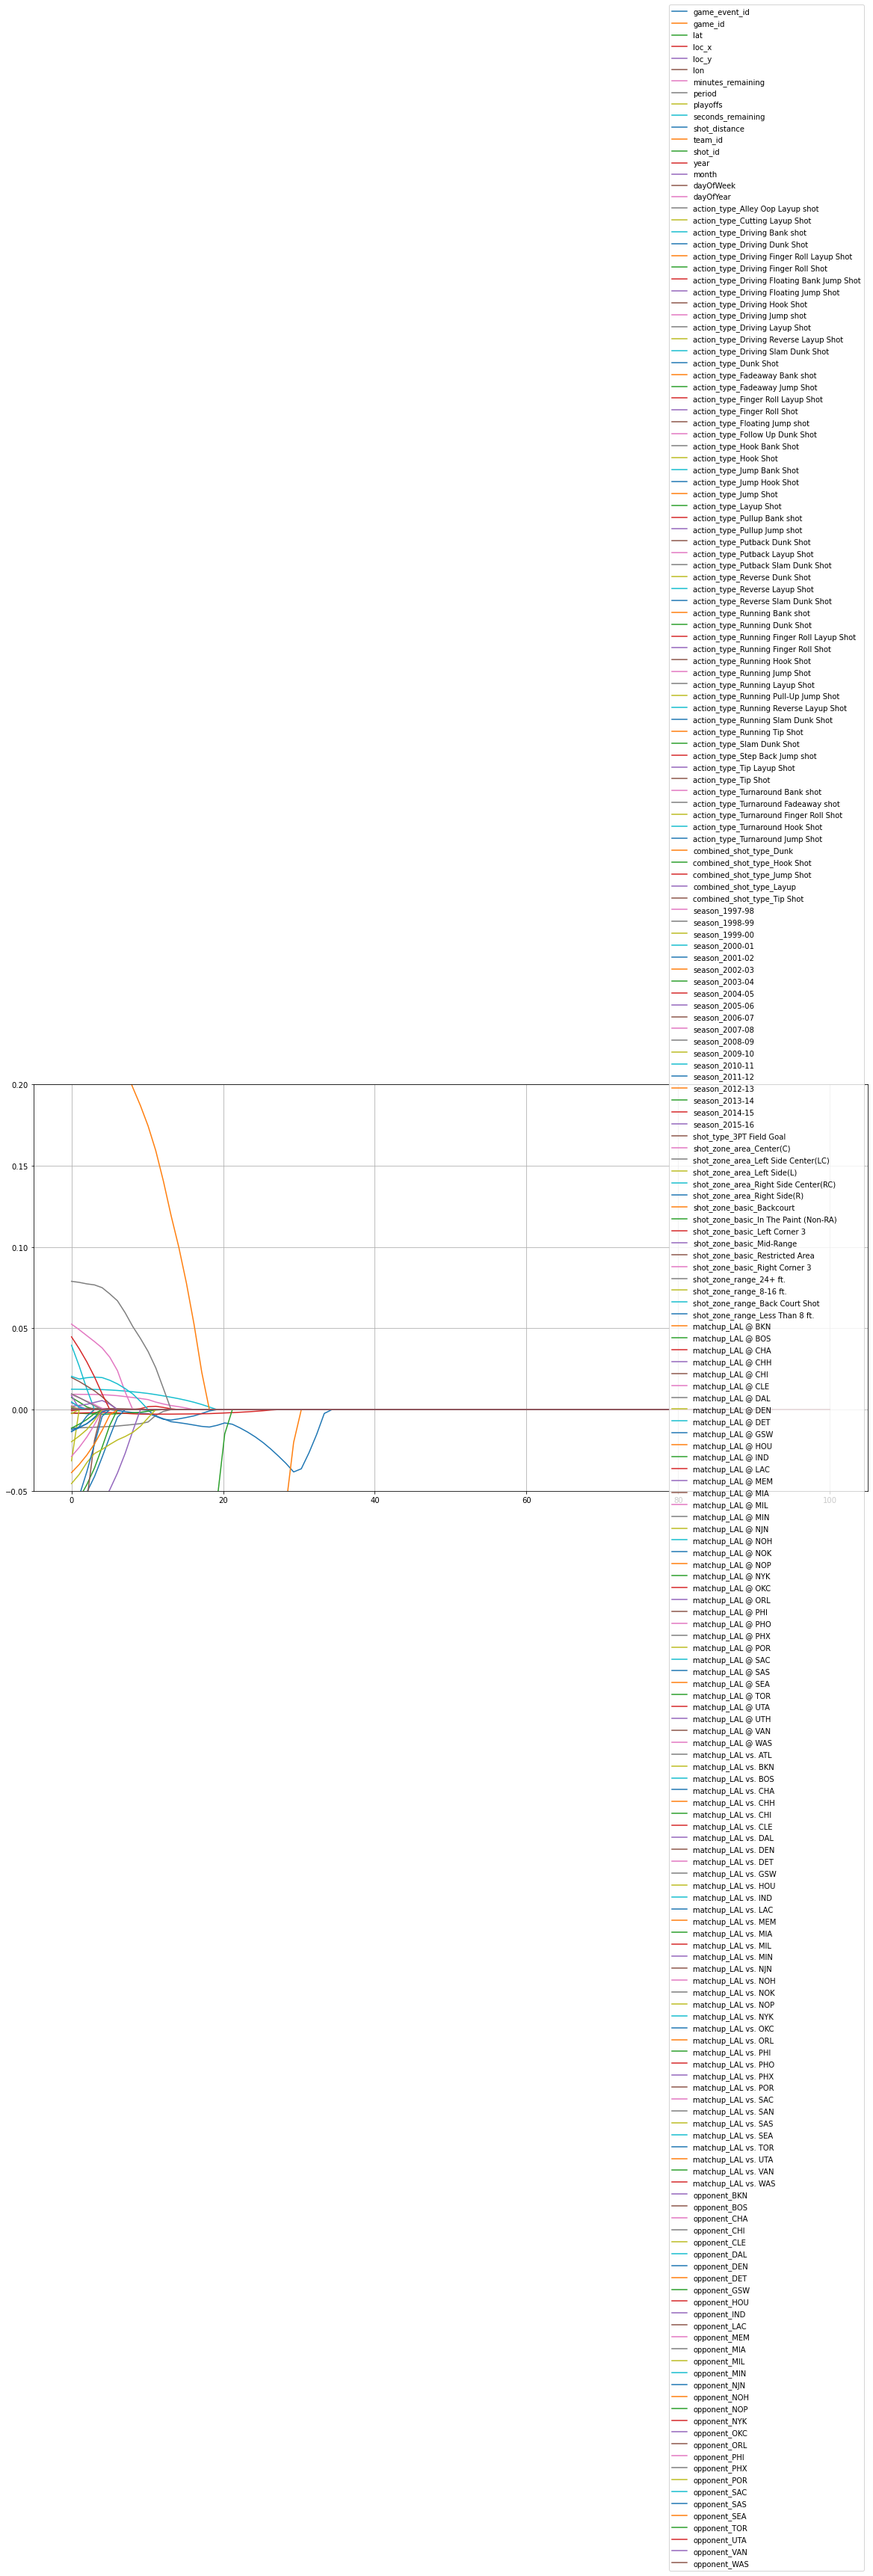

In [40]:
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(features_train, target_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=(20, 10))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.05,0.2)  
plt.legend(features_train.columns, loc='center right')  
plt.grid()


Не особо понятно. Попробуем посмотреть всё, что не зануляется

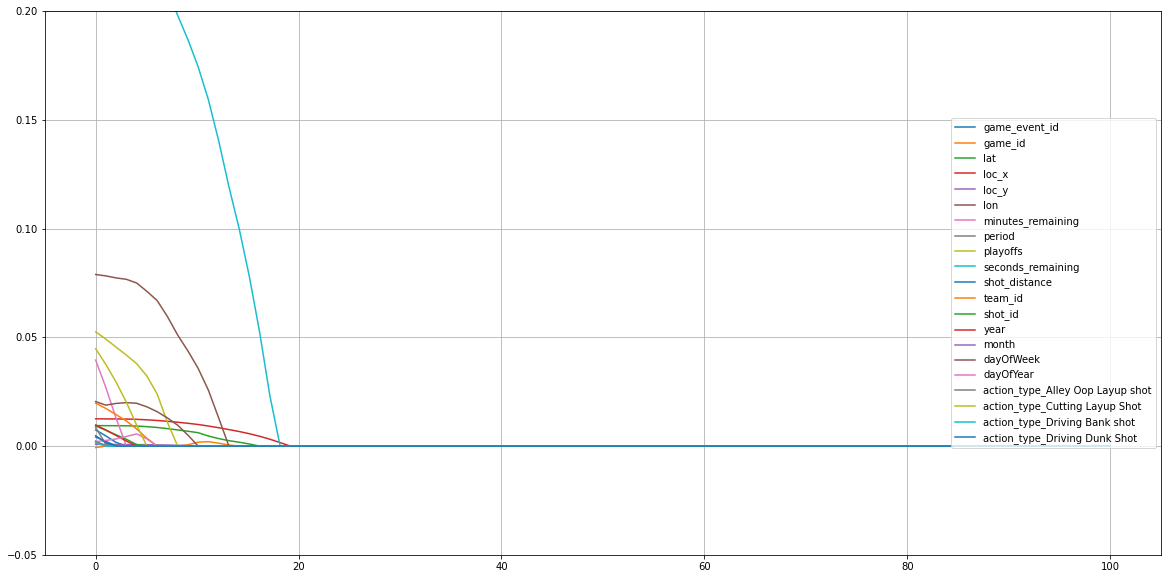

In [42]:
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(features_train, target_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=(20, 10))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    val = np.sign(i)*np.abs(i)
    if val.mean() > 0:
        plt.plot(x_l, val)
plt.ylim(-0.05,0.2)  
plt.legend(features_train.columns, loc='center right')  
plt.grid()


Получившиеся столбцы перекликаются с теми, что мы вывели по результатам работы модели. Возьмем их все за основу

In [43]:
features_important.sort_values('score')['feature'].head(10).tolist()

['action_type_Jump Shot',
 'action_type_Layup Shot',
 'combined_shot_type_Layup',
 'combined_shot_type_Jump Shot',
 'shot_zone_basic_In The Paint (Non-RA)',
 'season_2015-16',
 'shot_zone_range_Less Than 8 ft.',
 'shot_distance',
 'shot_zone_area_Left Side(L)',
 'season_2003-04']

In [50]:
new_columns = ['game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 
               'seconds_remaining', 'shot_distance', 'team_id', 'shot_id', 'year', 'month', 'dayOfWeek', 'dayOfYear',
              'action_type_Alley Oop Layup shot', 'action_type_Cutting Layup Shot', 'action_type_Driving Bank shot',
              'action_type_Driving Dunk Shot', 'shot_zone_area_Right Side Center(RC)', 'action_type_Turnaround Jump Shot',
              'action_type_Fadeaway Jump Shot', 'action_type_Jump Bank Shot', 'action_type_Pullup Jump shot', 
               'action_type_Slam Dunk Shot', 'action_type_Running Jump Shot', 'action_type_Driving Layup Shot', 
               'combined_shot_type_Dunk', 'action_type_Jump Shot', 'action_type_Layup Shot', 'combined_shot_type_Layup', 
               'combined_shot_type_Jump Shot', 'shot_zone_basic_In The Paint (Non-RA)', 'season_2015-16', 'season_2003-04', 'shot_distance', 
               'shot_zone_area_Left Side(L)', 'shot_zone_range_Less Than 8 ft.', 'shot_id']

#### Теперь снова формируем фичи ####

In [51]:
new_features_train = features_train[new_columns]
new_features_valid = features_valid[new_columns]
new_features_test = features_test[new_columns]

Теперь снова обучим модель и посмотрим, какие признаки покажут себя лучше всех

In [52]:
log_reg = LogisticRegression(random_state=12345).fit(new_features_train, target_train)
print(classification_report(target_valid, log_reg.predict(new_features_valid), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.67      0.83      0.74      2846
     class 1       0.70      0.48      0.57      2293

    accuracy                           0.68      5139
   macro avg       0.68      0.66      0.66      5139
weighted avg       0.68      0.68      0.67      5139



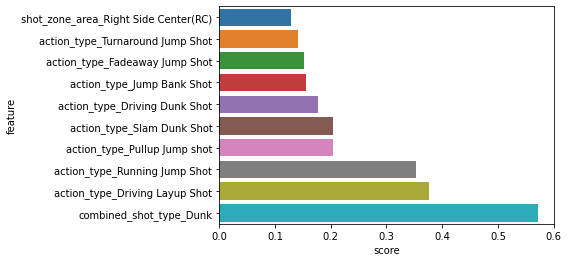

In [53]:
sns.barplot(x="score", y="feature", data=features_important.sort_values('score').tail(10))
plt.show()

Результат получился несколько хуже, чем раньше. Попробуем оставить только первые 10 по важности фичей. И из них сгенерируем признаки при помощи полинома

In [54]:
poly = PolynomialFeatures(2)

In [55]:
f_train_poly = poly.fit_transform(new_features_train[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
f_valid_poly = poly.fit_transform(new_features_valid[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
f_test_poly = poly.fit_transform(new_features_test[(features_important.sort_values('score')['feature'].tail(10).tolist()) and (features_important.sort_values('score')['feature'].head(10).tolist())])
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x3 x8',
 'x3 x9',
 'x3 x10',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x4 x8',
 'x4 x9',
 'x4 x10',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x8',
 'x5 x9',
 'x5 x10',
 'x6^2',
 'x6 x7',
 'x6 x8',
 'x6 x9',
 'x6 x10',
 'x7^2',
 'x7 x8',
 'x7 x9',
 'x7 x10',
 'x8^2',
 'x8 x9',
 'x8 x10',
 'x9^2',
 'x9 x10',
 'x10^2']

In [56]:
f_train_poly.shape, f_valid_poly.shape, f_test_poly.shape

((15418, 78), (5139, 78), (5140, 78))

#### Обучим линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках ####

In [57]:
log_reg_poly = LogisticRegression().fit(f_train_poly, target_train)
weights_log_reg_poly = log_reg_poly.coef_
print('Weights: {}'.format(log_reg_poly.coef_))
print('Bias: {}'.format(log_reg_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, log_reg_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.08966628 -0.47334287 -0.24216986 -0.37826554  0.22793418 -0.08331711
  -0.33077626 -0.30398757 -0.28016694 -0.28016694  0.19195234 -0.08366822
  -0.47334287  0.          0.         -0.47334287 -0.02588424  0.26738752
  -0.22949321  0.17519064  0.17519064 -0.09018193  0.17318909 -0.24216986
  -0.24216986  0.          0.37473828  0.26293336  0.14859395  0.31017698
   0.31017698 -0.10217744  0.03941445 -0.37826554  0.          0.02858744
   0.47261293 -0.03310719  0.00726381  0.00726381 -0.10217744  0.69792042
   0.22793418  0.49436678 -0.08686233 -0.00095909  0.46998009  0.46998009
  -0.49920855 -0.19631292 -0.08331711 -0.32645695 -0.54564924 -0.17821966
  -0.17821966 -0.1789432  -0.01001987 -0.33077626  0.02500727 -0.06014581
  -0.06014581  0.37720253  0.         -0.30398757 -0.88895556 -0.88895556
   0.         -0.29228891 -0.18324157 -0.18324157 -0.02356807  0.01748954
  -0.18324157 -0.02356807  0.01748954  0.19195234  0.2071326  -0.08366822]]
Bias: [0.14756858]

 Classi

На данный момент самый высокий результат. Видно, что модель стала немного лучше выявлять 1 класс. Попробуем построить модели с регуляризацией L1 и L2. Начнем с модели Lasso.

In [58]:
lasso_poly = Lasso(alpha=0.001).fit(f_train_poly, target_train)
weights_lasso = lasso_poly.coef_
print('Weights: {}'.format(lasso_poly.coef_))
print('Bias: {}'.format(lasso_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, lasso_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [ 0.00000000e+00 -3.19549712e-01 -0.00000000e+00 -7.14058194e-02
 -0.00000000e+00  0.00000000e+00 -2.25034077e-02 -0.00000000e+00
 -2.72362711e-02 -1.76967447e-16 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -6.71209131e-02  5.06035297e-02
  3.54352671e-17 -6.83998773e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.34136547e-01  9.15382956e-16 -0.00000000e+00
  0.00000000e+00 -3.22224653e-03  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -6.55912303e-02 -2.59681507e-02  0.00000000e+00  0.00000000e+00
 -2.53225912e-02 -1.99772175e-02  0.00000000e+00 -0.00000000e+00
 -3.42729639e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.69070317e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00

Также рассмотрим вариант, где регуляризацию L1 можно применить к модели логистической регрессии. Тогда у нас тоже получится Лассo

In [59]:
lasso = LogisticRegression(C = 0.2, penalty= 'l1', solver= 'liblinear').fit(f_train_poly, target_train)
weights_lasso1 = lasso.coef_
print('Weights: {}'.format(lasso.coef_))
print('Bias: {}'.format(lasso.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, lasso.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.33627933 -0.19684093 -0.03860582 -0.37542116  0.11518739  0.
  -0.17269921  0.         -0.04725361 -0.10549786  0.          0.
  -0.88053332  0.          0.         -0.27864136  0.          0.
  -0.27975439  0.13400269  0.19544171 -0.11338189  0.         -0.30881291
   0.          0.          0.          0.          0.          0.13722475
   0.63089087  0.          0.         -0.28168595  0.          0.
   0.          0.          0.          0.          0.          0.07420469
   0.00903525  0.29501997 -0.41070545 -0.16374439  0.17617932  0.21177566
  -0.09169218 -0.16665593  0.          0.         -0.48062675  0.
   0.          0.         -0.0241635  -0.00803679  0.          0.
   0.          0.          0.          0.         -0.68286058 -0.58438504
   0.          0.         -0.11721609 -0.17531132  0.          0.
  -0.13788534  0.          0.          0.          0.          0.        ]]
Bias: [0.19695407]

 Classification_report
              precision    recall  f1-sc

Поиграв с коэффициентом регуляризации, мы смогли придти к тому же результату.

Итак, модель Лассо показала результат немного выше, чем обычная линейная модель. Метрика F1 в отношении выявления класса 1 стала выше, также как и метрика accuracy.

Построим модель Ridge

In [60]:
ridge_poly = RidgeClassifier(alpha=0.005).fit(f_train_poly, target_train)
weights_ridge = ridge_poly.coef_
print('Weights: {}'.format(ridge_poly.coef_))
print('Bias: {}'.format(ridge_poly.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, ridge_poly.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.         -0.21299076 -0.44083888  0.14299554  0.15449657  0.02066779
  -0.29872318 -0.25118135 -0.18686823 -0.18686823  0.14501771 -0.02518502
  -0.21299076  0.          0.         -0.21299076 -0.06882486  0.20331695
  -0.14807844  0.03706626  0.03706626 -0.06723345  0.11536128 -0.44083889
  -0.44083889  0.          0.44162564  0.10618441  1.41993942  0.27783145
   0.27783145 -0.09197636  0.03024882  0.1429955   0.         -0.29649731
   0.49061053 -0.12246374  0.14797493  0.14797493 -0.09197636  0.25382026
   0.15449653  0.10548437  0.21232711 -0.03667743  0.1736796   0.1736796
  -0.36655692 -0.15415245  0.0206678  -0.14624638  0.19522032  0.08163264
   0.08163264  0.00776875  0.02318686 -0.29872318  0.06001097 -0.03199282
  -0.03199282  0.16747557  0.         -0.25118134 -0.26765364 -0.26765364
   0.         -0.10341819 -0.01392531 -0.01392531  0.05393466  0.00904934
  -0.01392531  0.05393466  0.00904934  0.14501767  0.10249716 -0.02518503]]
Bias: [0.02858708]

 Classif

Показатель полноты стал чуть меньше, macro avg также упал. Можно сказать, что на валидации модель с регуляризацией L1 - Lasso - себя показала лучше всего.

Посмотрим, что покажет логистическая регрессия с регуляризацией L2 - по сути тот же Ridge

In [61]:
ridge = LogisticRegression(C = 0.1, penalty= 'l2').fit(f_train_poly, target_train)
weights_ridge1 = ridge.coef_
print('Weights: {}'.format(ridge.coef_))
print('Bias: {}'.format(ridge.intercept_))

print('\n', 'Classification_report')
print(classification_report(target_valid, ridge.predict(f_valid_poly).round(), target_names=['class 0', 'class 1']))

Weights: [[ 0.04097813 -0.45737201 -0.22509803 -0.23673856  0.12239502 -0.04608065
  -0.22188912 -0.07525946 -0.23273725 -0.23273725  0.01621284 -0.05172861
  -0.45737201  0.          0.         -0.45737201 -0.03753819  0.13068571
  -0.23031696  0.17418167  0.17418167 -0.12236007  0.08209515 -0.22509803
  -0.22509803  0.          0.09746324  0.10796074 -0.09693853  0.23759584
   0.23759584 -0.03249588  0.08755031 -0.23673856  0.         -0.06920886
   0.20193606 -0.11272302  0.04620174  0.04620174 -0.03249588  0.3211546
   0.12239502  0.39429267 -0.19381345 -0.10762362  0.33785928  0.33785928
  -0.15309033 -0.16175718 -0.04608065 -0.23275932 -0.40040717 -0.04164071
  -0.04164071 -0.06167663 -0.09685672 -0.22188912  0.00110534 -0.04881652
  -0.04881652  0.15728498  0.         -0.07525946 -0.58852065 -0.58852065
   0.         -0.1121264  -0.14550057 -0.14550057  0.02124789  0.00938238
  -0.14550057  0.02124789  0.00938238  0.01621284  0.11977832 -0.05172861]]
Bias: [0.40160452]

 Classif

Построим графики коэффициентов для трех разных моделей

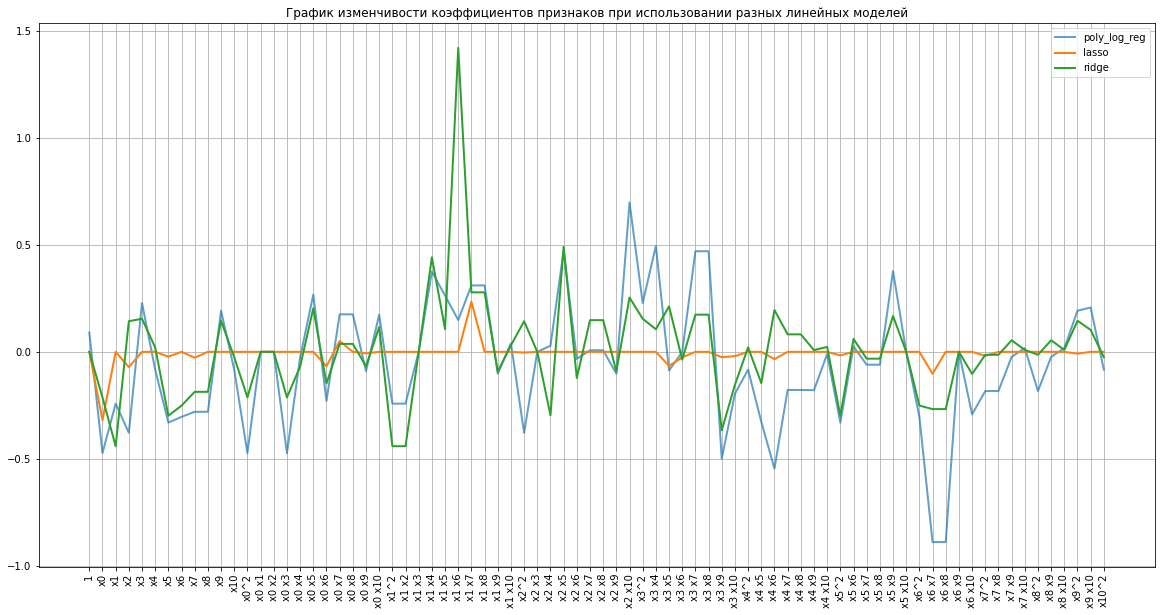

In [62]:
plt.figure(figsize=(20, 10))
plt.plot(poly.get_feature_names(), weights_log_reg_poly[0], alpha=0.7, label="poly_log_reg", lw=2, mec='b', mew=2, ms=10)
plt.plot(poly.get_feature_names(), weights_lasso, label="lasso", mec='r', lw=2, mew=2, ms=12)
plt.plot(poly.get_feature_names(), weights_ridge[0], label="ridge", mec='g', lw=2, mew=2, ms=14)
plt.legend()
plt.title("График изменчивости коэффициентов признаков при использовании разных линейных моделей")
plt.grid(True)
plt.tick_params(axis='x', rotation=90)

Итак, что мы видим: больше всего зануляются коэффициенты модели Lasso. Самые большие колебания видны у модели логистической регрессии, хотя она показала результат лучше, чем модель Ridge. При этом есть такие коэффициенты, которые в разных моделях имеют абсолютно разное значение. Так, например, признак "x3 x5" в модели Ridge имеет коэффициент больше нуля ("гора"), а у моделей Lasso и логистической регрессии - наоборот отрицательное значение ("впадина"). А признак "x6 x7" имеет очень большое отрицательное значение коэффициента в модели логистической регрессии, а у остальных - отрицательное, но довольно маленькое значение. При этом есть признак "х0 * х1", где все 3 модели зануляют коэффициент, т.е. по сути этот признак нам не нужен.